In [1]:
# unzip dataset_letras.zip
!unzip dataset_numeros_final.zip

Streaming output truncated to the last 5000 lines.
 extracting: dataset_numeros3/0/0_106.png  
 extracting: dataset_numeros3/0/0_107.png  
 extracting: dataset_numeros3/0/0_108.png  
 extracting: dataset_numeros3/0/0_109.png  
 extracting: dataset_numeros3/0/0_11.png  
 extracting: dataset_numeros3/0/0_110.png  
 extracting: dataset_numeros3/0/0_111.png  
 extracting: dataset_numeros3/0/0_112.png  
 extracting: dataset_numeros3/0/0_113.png  
 extracting: dataset_numeros3/0/0_114.png  
 extracting: dataset_numeros3/0/0_115.png  
 extracting: dataset_numeros3/0/0_116.png  
 extracting: dataset_numeros3/0/0_117.png  
 extracting: dataset_numeros3/0/0_118.png  
 extracting: dataset_numeros3/0/0_119.png  
 extracting: dataset_numeros3/0/0_12.png  
 extracting: dataset_numeros3/0/0_120.png  
 extracting: dataset_numeros3/0/0_121.png  
 extracting: dataset_numeros3/0/0_122.png  
 extracting: dataset_numeros3/0/0_123.png  
 extracting: dataset_numeros3/0/0_124.png  
 extracting: dataset_numero

In [2]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.0/311.0 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.7 MB/s eta 0:00:00


In [3]:
import wandb

## Login
wandb.login(key='a14c6a2ec25620e6e2047f787c8dbe5d7710eaef')

## Inicializa WandB
wandb.init(project="repte1_psiv", entity="andreu-mir")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: andreu-mir. Use `wandb login --relogin` to force relogin


# 1. Arquitectura model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Definir las capas convolucionales y de agrupamiento
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # Capa convolucional 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPooling 1

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # Capa convolucional 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPooling 2

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Capa convolucional 3
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPooling 3

        # Ajustar la capa fully connected para 26 clases
        self.fc1 = nn.Linear(128 * 8 * 5, 128)  # Capa densa
        self.dropout = nn.Dropout(0.5)  # Dropout para regularización
        self.fc2 = nn.Linear(128, 26)  # Capa de salida ajustada a 26 clases

    def forward(self, x):
        # Definir el paso hacia adelante
        x = self.pool1(F.relu(self.conv1(x)))  # Capa 1
        x = self.pool2(F.relu(self.conv2(x)))  # Capa 2
        x = self.pool3(F.relu(self.conv3(x)))  # Capa 3

        x = x.view(-1, 128 * 8 * 5)  # Aplanar la salida para la capa densa
        x = F.relu(self.fc1(x))  # Capa densa
        x = self.dropout(x)  # Aplicar dropout
        x = self.fc2(x)  # Capa de salida

        return x

# Crear una instancia del modelo
model = CNNModel()


# 2. Dataset

In [5]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import KFold
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import wandb
import seaborn as sns
import matplotlib.pyplot as plt

# Inicializar WandB
wandb.init(project="number_recognition_cnn")

# Definición de parámetros
batch_size = 32
img_height, img_width = 64, 40  # Tamaño de las imágenes

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),  # Redimensionar las imágenes
    transforms.Grayscale(num_output_channels=1),  # Asegurarse de que la imagen sea en escala de grises
    transforms.ToTensor(),  # Convertir imágenes a tensores
    transforms.Normalize((0.5,), (0.5,)),  # Normalizar las imágenes (grayscale)
])

# Cargar el dataset
base_dir = 'dataset_numeros3'
dataset = datasets.ImageFolder(root=base_dir, transform=transform)

# Número de pliegues para la validación cruzada
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

# Verificación
print(f"Total dataset size: {len(dataset)}")

Total dataset size: 5000


# 3. Train Model

In [6]:
import torch.nn as nn
import torch.optim as optim

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# see shape of dataset_letras\0\0_0.png

print(dataset[0][0].shape)

torch.Size([1, 64, 40])


Fold 1/5
Epoch [1/20], Loss: 0.9394, Accuracy: 0.7262
Epoch [2/20], Loss: 0.3571, Accuracy: 0.8950
Epoch [3/20], Loss: 0.2769, Accuracy: 0.9107
Epoch [4/20], Loss: 0.2288, Accuracy: 0.9255
Epoch [5/20], Loss: 0.2038, Accuracy: 0.9337
Epoch [6/20], Loss: 0.1714, Accuracy: 0.9400
Epoch [7/20], Loss: 0.1577, Accuracy: 0.9463
Epoch [8/20], Loss: 0.1354, Accuracy: 0.9530
Epoch [9/20], Loss: 0.1139, Accuracy: 0.9583
Epoch [10/20], Loss: 0.1126, Accuracy: 0.9607
Epoch [11/20], Loss: 0.1040, Accuracy: 0.9597
Epoch [12/20], Loss: 0.1065, Accuracy: 0.9603
Epoch [13/20], Loss: 0.0834, Accuracy: 0.9700
Epoch [14/20], Loss: 0.0773, Accuracy: 0.9725
Epoch [15/20], Loss: 0.0701, Accuracy: 0.9758
Epoch [16/20], Loss: 0.0660, Accuracy: 0.9785
Epoch [17/20], Loss: 0.0737, Accuracy: 0.9755
Epoch [18/20], Loss: 0.0601, Accuracy: 0.9762
Epoch [19/20], Loss: 0.0591, Accuracy: 0.9772
Epoch [20/20], Loss: 0.0425, Accuracy: 0.9845
Validation Loss: 0.1703, Validation Accuracy: 0.9610
Validation Precision: 0.961

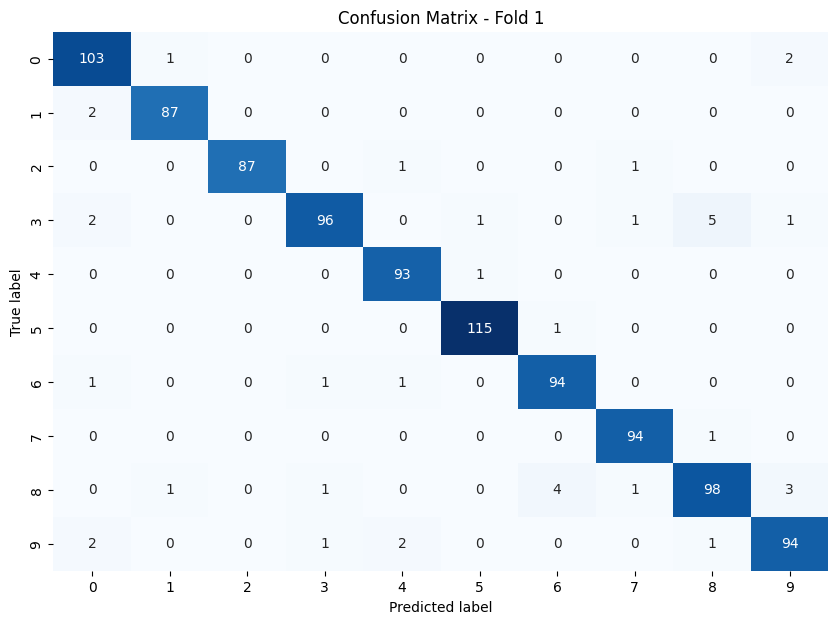

Fold 2/5
Epoch [1/20], Loss: 0.1028, Accuracy: 0.9712
Epoch [2/20], Loss: 0.0792, Accuracy: 0.9732
Epoch [3/20], Loss: 0.0543, Accuracy: 0.9802
Epoch [4/20], Loss: 0.0473, Accuracy: 0.9825
Epoch [5/20], Loss: 0.0435, Accuracy: 0.9828
Epoch [6/20], Loss: 0.0429, Accuracy: 0.9840
Epoch [7/20], Loss: 0.0352, Accuracy: 0.9890
Epoch [8/20], Loss: 0.0376, Accuracy: 0.9875
Epoch [9/20], Loss: 0.0321, Accuracy: 0.9895
Epoch [10/20], Loss: 0.0441, Accuracy: 0.9852
Epoch [11/20], Loss: 0.0332, Accuracy: 0.9870
Epoch [12/20], Loss: 0.0336, Accuracy: 0.9870
Epoch [13/20], Loss: 0.0321, Accuracy: 0.9875
Epoch [14/20], Loss: 0.0341, Accuracy: 0.9862
Epoch [15/20], Loss: 0.0262, Accuracy: 0.9905
Epoch [16/20], Loss: 0.0242, Accuracy: 0.9908
Epoch [17/20], Loss: 0.0273, Accuracy: 0.9872
Epoch [18/20], Loss: 0.0289, Accuracy: 0.9905
Epoch [19/20], Loss: 0.0225, Accuracy: 0.9915
Epoch [20/20], Loss: 0.0292, Accuracy: 0.9888
Validation Loss: 0.0654, Validation Accuracy: 0.9840
Validation Precision: 0.984

<Figure size 640x480 with 0 Axes>

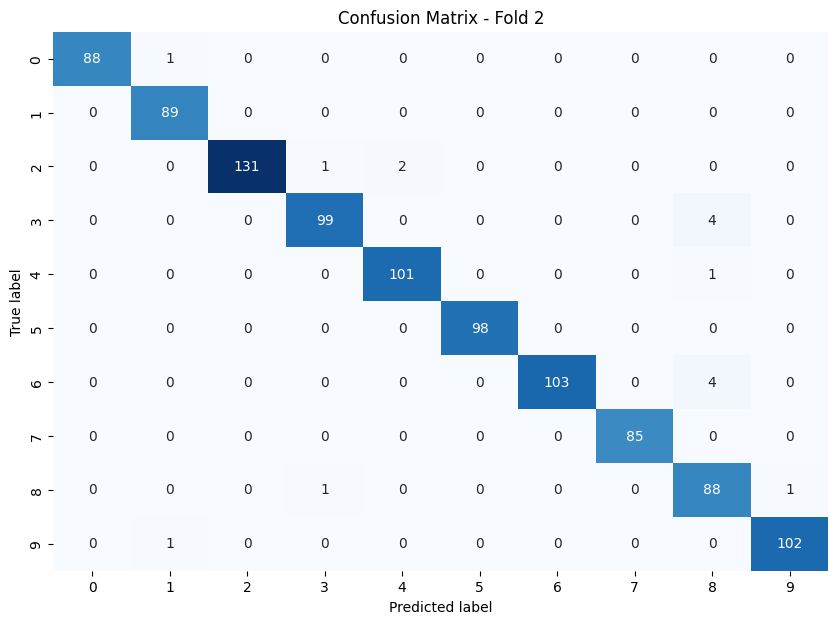

Fold 3/5
Epoch [1/20], Loss: 0.0509, Accuracy: 0.9838
Epoch [2/20], Loss: 0.0437, Accuracy: 0.9860
Epoch [3/20], Loss: 0.0275, Accuracy: 0.9902
Epoch [4/20], Loss: 0.0271, Accuracy: 0.9915
Epoch [5/20], Loss: 0.0196, Accuracy: 0.9922
Epoch [6/20], Loss: 0.0238, Accuracy: 0.9925
Epoch [7/20], Loss: 0.0245, Accuracy: 0.9920
Epoch [8/20], Loss: 0.0201, Accuracy: 0.9928
Epoch [9/20], Loss: 0.0211, Accuracy: 0.9930
Epoch [10/20], Loss: 0.0271, Accuracy: 0.9912
Epoch [11/20], Loss: 0.0151, Accuracy: 0.9955
Epoch [12/20], Loss: 0.0191, Accuracy: 0.9928
Epoch [13/20], Loss: 0.0209, Accuracy: 0.9918
Epoch [14/20], Loss: 0.0153, Accuracy: 0.9925
Epoch [15/20], Loss: 0.0205, Accuracy: 0.9930
Epoch [16/20], Loss: 0.0153, Accuracy: 0.9952
Epoch [17/20], Loss: 0.0167, Accuracy: 0.9932
Epoch [18/20], Loss: 0.0117, Accuracy: 0.9948
Epoch [19/20], Loss: 0.0216, Accuracy: 0.9912
Epoch [20/20], Loss: 0.0158, Accuracy: 0.9948
Validation Loss: 0.0089, Validation Accuracy: 0.9960
Validation Precision: 0.996

<Figure size 640x480 with 0 Axes>

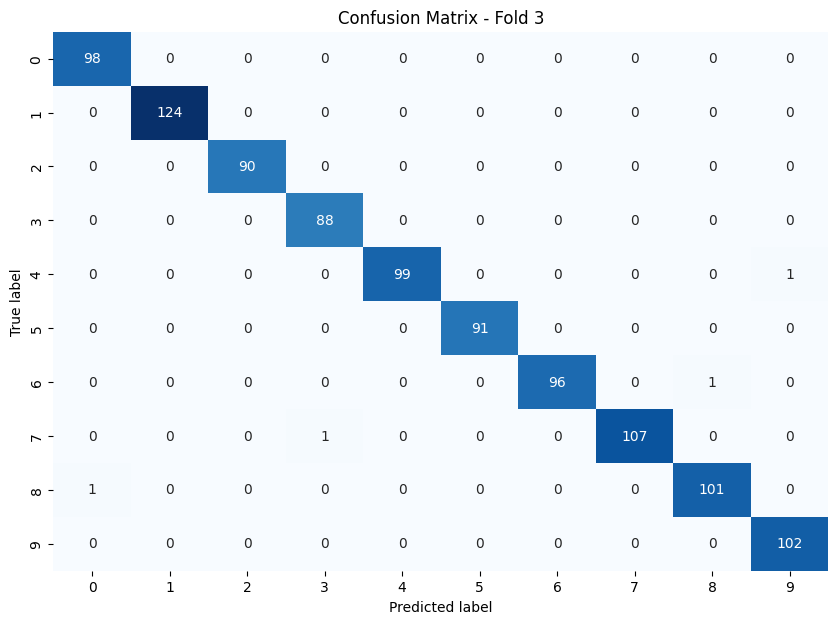

Fold 4/5
Epoch [1/20], Loss: 0.0267, Accuracy: 0.9905
Epoch [2/20], Loss: 0.0273, Accuracy: 0.9920
Epoch [3/20], Loss: 0.0170, Accuracy: 0.9948
Epoch [4/20], Loss: 0.0174, Accuracy: 0.9945
Epoch [5/20], Loss: 0.0162, Accuracy: 0.9935
Epoch [6/20], Loss: 0.0189, Accuracy: 0.9938
Epoch [7/20], Loss: 0.0232, Accuracy: 0.9920
Epoch [8/20], Loss: 0.0190, Accuracy: 0.9938
Epoch [9/20], Loss: 0.0131, Accuracy: 0.9955
Epoch [10/20], Loss: 0.0122, Accuracy: 0.9950
Epoch [11/20], Loss: 0.0090, Accuracy: 0.9970
Epoch [12/20], Loss: 0.0105, Accuracy: 0.9970
Epoch [13/20], Loss: 0.0122, Accuracy: 0.9948
Epoch [14/20], Loss: 0.0141, Accuracy: 0.9952
Epoch [15/20], Loss: 0.0228, Accuracy: 0.9920
Epoch [16/20], Loss: 0.0095, Accuracy: 0.9965
Epoch [17/20], Loss: 0.0101, Accuracy: 0.9952
Epoch [18/20], Loss: 0.0087, Accuracy: 0.9972
Epoch [19/20], Loss: 0.0086, Accuracy: 0.9970
Epoch [20/20], Loss: 0.0113, Accuracy: 0.9955
Validation Loss: 0.0012, Validation Accuracy: 0.9990
Validation Precision: 0.999

<Figure size 640x480 with 0 Axes>

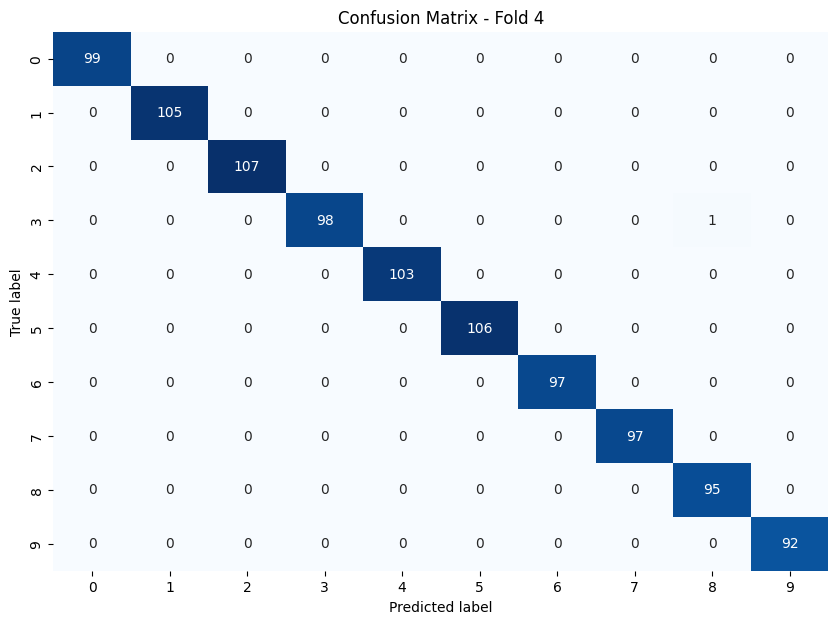

Fold 5/5
Epoch [1/20], Loss: 0.0141, Accuracy: 0.9945
Epoch [2/20], Loss: 0.0193, Accuracy: 0.9930
Epoch [3/20], Loss: 0.0207, Accuracy: 0.9930
Epoch [4/20], Loss: 0.0138, Accuracy: 0.9960
Epoch [5/20], Loss: 0.0154, Accuracy: 0.9942
Epoch [6/20], Loss: 0.0132, Accuracy: 0.9952
Epoch [7/20], Loss: 0.0075, Accuracy: 0.9972
Epoch [8/20], Loss: 0.0139, Accuracy: 0.9950
Epoch [9/20], Loss: 0.0084, Accuracy: 0.9972
Epoch [10/20], Loss: 0.0075, Accuracy: 0.9965
Epoch [11/20], Loss: 0.0097, Accuracy: 0.9960
Epoch [12/20], Loss: 0.0146, Accuracy: 0.9950
Epoch [13/20], Loss: 0.0055, Accuracy: 0.9975
Epoch [14/20], Loss: 0.0072, Accuracy: 0.9978
Epoch [15/20], Loss: 0.0155, Accuracy: 0.9930
Epoch [16/20], Loss: 0.0153, Accuracy: 0.9950
Epoch [17/20], Loss: 0.0100, Accuracy: 0.9970
Epoch [18/20], Loss: 0.0151, Accuracy: 0.9960
Epoch [19/20], Loss: 0.0094, Accuracy: 0.9965
Epoch [20/20], Loss: 0.0112, Accuracy: 0.9965
Validation Loss: 0.0010, Validation Accuracy: 1.0000
Validation Precision: 1.000

<Figure size 640x480 with 0 Axes>

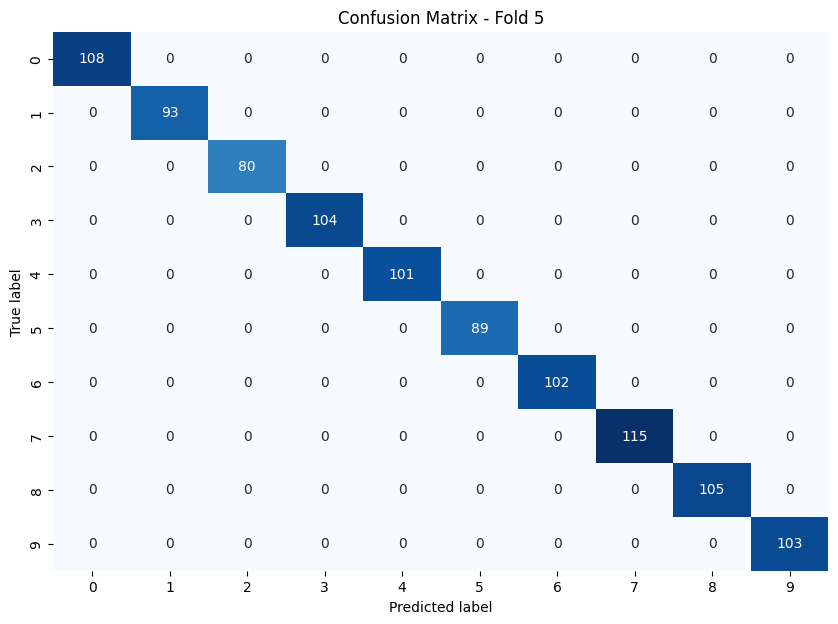

<Figure size 640x480 with 0 Axes>

In [8]:
# Loop a través de los pliegues
for fold, (train_indices, val_indices) in enumerate(kfold.split(range(len(dataset)))):
    print(f'Fold {fold + 1}/{num_folds}')

    # Crear subconjuntos de entrenamiento y validación
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)

    # Crear DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Mover el modelo a la GPU
    model.to('cuda')

    train_losses = []
    train_accuracies = []

    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to('cuda')  # Usa 'cuda' si tienes GPU
            labels = labels.to('cuda')  # Usa 'cuda' si tienes GPU

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calcular precisión
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calcula y registra la pérdida y la precisión
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Log metrics to WandB
        wandb.log({
            "epoch": epoch + 1,
            "loss": epoch_loss,
            "accuracy": epoch_accuracy,
        })

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    # Validación
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    val_labels = []
    val_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            # Calcular precisión
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(predicted.cpu().numpy())

    # Calcula y muestra la pérdida y precisión de validación
    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_accuracy = val_correct / val_total

    # Calcular métricas adicionales
    precision = precision_score(val_labels, val_predictions, average='weighted')
    recall = recall_score(val_labels, val_predictions, average='weighted')
    f1 = f1_score(val_labels, val_predictions, average='weighted')
    cm = confusion_matrix(val_labels, val_predictions)

    # Log métricas de validación a WandB
    wandb.log({
        "fold": fold + 1,
        "val_loss": val_epoch_loss,
        "val_accuracy": val_epoch_accuracy,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1,
    })

    # Imprimir métricas
    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}')
    print(f'Validation Precision: {precision:.4f}')
    print(f'Validation Recall: {recall:.4f}')
    print(f'Validation F1 Score: {f1:.4f}')
    print('Confusion Matrix:')
    print(cm)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix - Fold {fold + 1}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Guardar la figura
    wandb.log({"confusion_matrix": wandb.Image(plt)})
    plt.show()
    plt.clf()  # Limpiar la figura para la próxima iteración




In [9]:
# Finaliza la sesión de WandB
wandb.finish()

accuracy,▁▇▇█▇▇██████████████████████████████████
epoch,▁▃▃▅▅▇█▁▃▃▅▅▆█▁▃▃▄▆▆▇█▁▁▃▄▅▆██▁▂▃▃▄▅▅▅▆▇
fold,▁▃▅▆█
loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▇██
val_f1,▁▅▇██
val_loss,█▄▁▁▁
val_precision,▁▅▇██
val_recall,▁▅▇██
accuracy,0.9965
epoch,20


In [10]:
model_save_path = f'model_number_classifier_cnn.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to model_number_classifier_cnn.pth
